In [1]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

from statsmodels.regression.quantile_regression import QuantReg

import sys
sys.path.append('../scripts/') 

from aux_funcs import label_encoder, load_ct_scans, competition_metric, extract_img_id, get_config, make_ct_git, filter_by_std
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow import keras
import tensorflow.keras.backend as K
from functools import partial
from sklearn.model_selection import GroupKFold

from sklearn.preprocessing import StandardScaler, MinMaxScaler

#######################################################

def encode_categorical(df):
    df['male'] = df.Sex.apply(lambda x: 1 if x == 'Male' else 0)
    df['female'] = df.Sex.apply(lambda x: 1 if x == 'Female' else 0)
    df['current_smoker'] = df.SmokingStatus.apply(lambda x: 1 if x == 'Currently smokes' else 0)
    df['ex_smoker'] = df.SmokingStatus.apply(lambda x: 1 if x == 'Ex-smoker' else 0)
    df['never_smoker'] = df.SmokingStatus.apply(lambda x: 1 if x == 'Never smoked' else 0)
    df.drop(['SmokingStatus','Sex'],1,inplace=True)

    return df

#######################################################


config = get_config()
train_df = pd.read_csv(config['data_path']+'/train.csv')
test_df = pd.read_csv(config['data_path']+'/test.csv')

mask_patients = [not(x in list(test_df['Patient'].values)) for x in list(train_df['Patient'].values)]
train_df = pd.DataFrame(train_df.values[mask_patients], columns=train_df.columns)

patient_2_remove = []

for patient in list(train_df['Patient'].values):
    if patient in list(test_df['Patient'].values):
        patient_2_remove.append(patient)
        
print('Train patients in test', np.unique(patient_2_remove).shape[0])

patient_encoder = LabelEncoder()
patient_label = patient_encoder.fit_transform(list(train_df['Patient'].values))

df_train = encode_categorical(train_df)
test_df = encode_categorical(test_df)

X = df_train.drop(['Patient', 'FVC'], 1)
cols_X = X.columns
X = X.values.astype(np.float32)
Y = df_train['FVC'].values.astype(np.float32)

Train patients in test 0


In [2]:
# EDA on FVC ; Filtering out bad cases

In [3]:
from sklearn.model_selection import train_test_split, GroupShuffleSplit

train_ids, test_ids = next(GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=195).split(X, groups=patient_label))
X_train, Y_train = X[train_ids], Y[train_ids]
X_test, Y_test = X[test_ids], Y[test_ids]

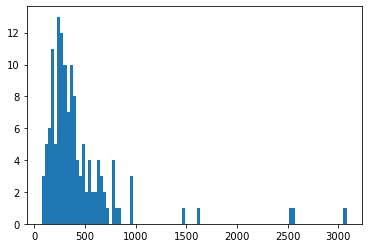

In [4]:
# Filtering out high acceleration patients -> not reliable ; remove above 900

acc_vals = []
for p in np.unique(patient_label[train_ids]):
    mask = patient_label[train_ids] == p
    vals = Y_train[mask]
    acc_vals.append(np.max(np.abs(np.diff(np.diff(vals)))))

plt.hist(acc_vals, bins=100)
plt.show()

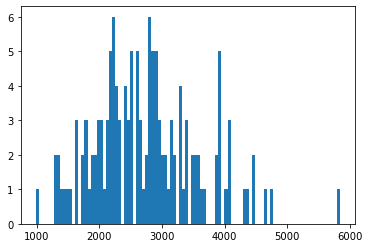

In [5]:
# Filtering out extreme cases ; remove above 5000 and below 1000
avg_vals = []
for p in np.unique(patient_label[train_ids]):
    mask = patient_label[train_ids] == p
    vals = Y_train[mask]
    avg_vals.append(np.mean(vals))

plt.hist(avg_vals, bins=100)
plt.show()

In [6]:
# Filtering out increasing patients -> not reliable
increasing_p = []
for p in np.unique(patient_label[train_ids]):
    mask = patient_label[train_ids] == p
    vals = Y_train[mask]
    if vals[0] < vals[-1]:
        increasing_p.append(p)

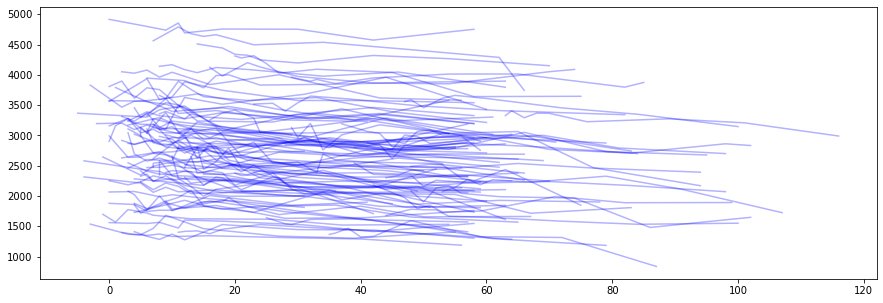

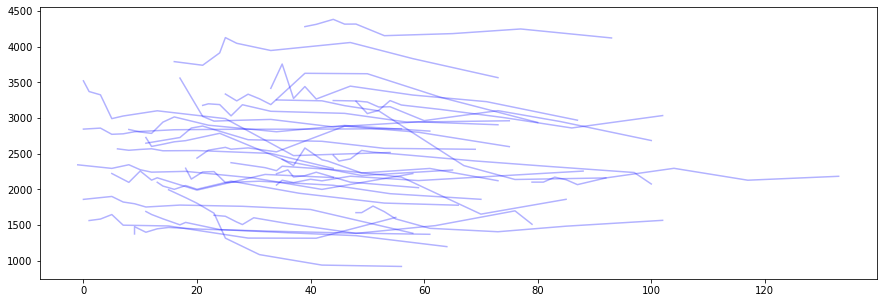

In [7]:
vals_y = []
X_train_filtered = []
Y_train_filtered = []
X_test_filtered = []
Y_test_filtered = []
patients_train_filtered = []
patients_test_filtered = []

plt.figure(figsize=(15,5))
for p in np.unique(patient_label[train_ids]):
    mask = patient_label[train_ids] == p
    if p in increasing_p:
        continue
    if np.max(np.abs(np.diff(np.diff(Y_train[mask])))) > 900 or np.mean(Y_train[mask]) > 5000 or np.mean(Y_train[mask]) < 1200:
        continue
    plt.plot(X_train[mask,0], Y_train[mask], alpha=0.3, c='b')
    vals_y.append(Y_train[mask])
    patients_train_filtered.append([p]*X_train[mask,0].shape[0])
    X_train_filtered.append(X_train[mask])
    Y_train_filtered.append(Y_train[mask])
plt.show()

plt.figure(figsize=(15,5))
for p in np.unique(patient_label[test_ids]):
    mask = patient_label[test_ids] == p
    if p in increasing_p:
        continue
    if np.max(np.abs(np.diff(np.diff(Y_test[mask])))) > 900 or np.mean(Y_test[mask]) > 5000 or np.mean(Y_test[mask]) < 1200:
        continue
    plt.plot(X_test[mask,0], Y_test[mask], alpha=0.3, c='b')
    vals_y.append(Y_test[mask])
    patients_test_filtered.append([p]*X_test[mask,0].shape[0])
    X_test_filtered.append(X_test[mask])
    Y_test_filtered.append(Y_test[mask])
plt.show()

X_train, X_test = np.concatenate(X_train_filtered,0), np.concatenate(X_test_filtered,0)
Y_train, Y_test = np.concatenate(Y_train_filtered,0), np.concatenate(Y_test_filtered,0)

In [8]:
patients_train = np.concatenate(patients_train_filtered)
patients_test = np.concatenate(patients_test_filtered)

In [9]:
cols_X

Index([&#39;Weeks&#39;, &#39;Percent&#39;, &#39;Age&#39;, &#39;male&#39;, &#39;female&#39;, &#39;current_smoker&#39;,
       &#39;ex_smoker&#39;, &#39;never_smoker&#39;],
      dtype=&#39;object&#39;)

In [188]:
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel, RationalQuadratic, RBF, DotProduct
from sklearn.gaussian_process import GaussianProcessRegressor

def build_gp(X, Y, scale, alpha, sigma):
    '''
    adding one SE kernel for each categorical dim and then a product between them
    '''
    '''k_sex_0 = RBF(length_scale=[0.0, 0.0, 0.0, scales[1], 0.0, 0.0, 0.0, 0.0])
    k_sex_1 = RBF(length_scale=[0.0, 0.0, 0.0, 0.0, scales[2], 0.0, 0.0, 0.0])
    k_sex = k_sex_0 * k_sex_1

    k_smoker_0 = RBF(length_scale=[0.0, 0.0, 0.0, 0.0, 0.0, scales[3], 0.0, 0.0])
    k_smoker_1 = RBF(length_scale=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, scales[4], 0.0])
    k_smoker_2 = RBF(length_scale=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, scales[5]])
    k_smoker = k_smoker_0 * k_smoker_1 * k_smoker_2
'''


    kernel = RationalQuadratic(length_scale=scale, alpha=alpha) + DotProduct(sigma)

    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, normalize_y=True, alpha=0)

    gp.fit(X, Y)

    return gp

def estimate_mae(gp,X,Y,t_Y):
    # t_Y weeks Y is defined -> [1,5,8,10]

    X_pred = np.hstack([np.arange(-12,134).reshape(-1,1), np.repeat(X, 146, axis=0)])
    y_pred = gp.predict(X_pred)

    return np.mean(np.abs(Y-y_pred[t_Y.astype(np.int)+12]))

In [189]:
length_scales_range = np.linspace(0.5,10,20)
alpha_range = np.exp(np.linspace(0.01,3,20))-1
sigma_range = np.linspace(0.1,1,1)

In [190]:
# https://juanitorduz.github.io/gaussian_process_time_series/

In [283]:
mae_configs = []
configs = []

n_tries = 100

for _ in tqdm(range(n_tries)):
    scales = np.random.choice(length_scales_range, size=1)
    alpha = np.random.choice(alpha_range, size=1)
    sigma = np.random.choice(sigma_range, size=1)

    config = [scales, alpha, sigma]
    configs.append(config)
    mae_vals = []

    group_kfold = GroupKFold(n_splits=5)
    for train_index, test_index in group_kfold.split(X_train, Y_train, patients_train):
        Xcv_train, Xcv_test = X_train[train_index], X_train[test_index]
        Ycv_train, Ycv_test = Y_train[train_index], Y_train[test_index]

        try:
            model_gp = build_gp(Xcv_train, Ycv_train, scale=config[0], alpha=config[1], sigma=config[2])
        except:
            mae_vals.append(1e6)
            continue

        vals_mae = []
        for i in range(Xcv_test.shape[0]):
            mask = patients_train[test_index] == patients_train[test_index][i]
            vals_mae.append(estimate_mae(model_gp, Xcv_test[i:i+1, 1:], Ycv_test[mask], Xcv_test[mask,0]))
        
        mae_vals.append(np.mean(vals_mae))

    mae_configs.append(np.mean(mae_vals))

100%|██████████| 100/100 [16:23&lt;00:00,  9.84s/it]


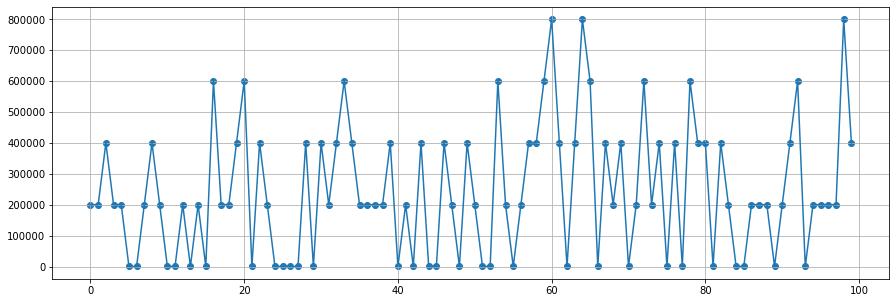

In [284]:
plt.figure(figsize=(15,5))
plt.plot(mae_configs)
plt.scatter(np.arange(len(mae_configs)), mae_configs)
plt.grid()
plt.show()

In [285]:
opt_config = configs[np.argmin(np.array(mae_configs))]
model_gp = build_gp(X_train, Y_train, scale=opt_config[0], alpha=opt_config[1], sigma=opt_config[2])

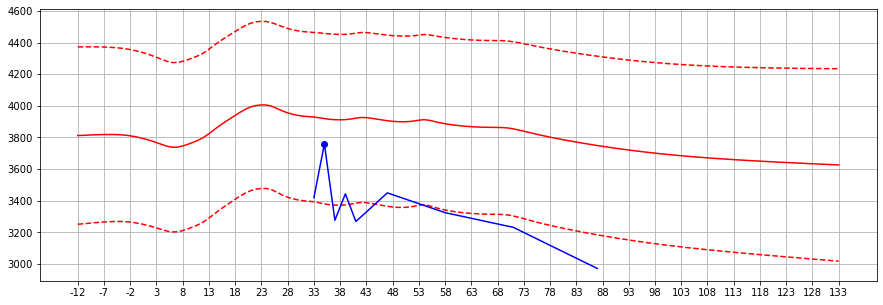

In [286]:
id_pat = np.random.randint(X_test.shape[0])
X_pred = np.hstack([np.arange(-12,134).reshape(-1,1), np.repeat(X_test[id_pat:id_pat+1, 1:], 146, axis=0)])
y_pred = model_gp.predict(X_pred, return_std=True)
plt.figure(figsize=(15,5))
plt.plot(np.arange(-12,134), y_pred[0], linestyle='-', c='r')
plt.plot(np.arange(-12,134), y_pred[0]+y_pred[1], linestyle='--', c='r')
plt.plot(np.arange(-12,134), y_pred[0]-y_pred[1], linestyle='--', c='r')
mask = patients_test == patients_test[id_pat]
plt.plot(X_test[mask,0], Y_test[mask], c='b')
plt.scatter(X_test[id_pat,0], Y_test[id_pat], c='b')
plt.xticks(np.arange(-12,134,5), np.arange(-12,134,5))
plt.grid()
plt.show()